In [1]:
# Load Dependencies
import numpy as np
import sys
import os
import matplotlib.pyplot as plt
import math
from statistics import mean

sys.path.append('Requirements/pygplates_rev28_python38_win64')      # <----- for windows users
# sys.path.append('Requirements/pygplates_rev28_python38_MacOS64')    # <----- for mac users
import pygplates

# Call compute_torques.py script
import compute_torques

In [7]:
os.remove('temp_coastlines.shx')

### Load plate model files

The plate model from Muller et al. (2016, AREPS), which is used as an example in this notebook, is provided. However, it is possible to load in any GPlates model as long as it has a rotation file, continuously closed plate topologies, and seafloor age grids.

In [12]:
# Load Plate Models
models = ['Muller_etal_2016']

# Load topology feature collections
topology_features = [[pygplates.FeatureCollection('Plate_model/Muller_etal_2016/Global_EarthByte_230-0Ma_GK07_AREPS_PlateBoundaries.gpml'),
                     pygplates.FeatureCollection('Plate_model/Muller_etal_2016/Global_EarthByte_230-0Ma_GK07_AREPS_Topology_BuildingBlocks.gpml')]]

# Load rotation files
rotation_model = [pygplates.RotationModel(['Plate_model/Muller_etal_2016/Global_EarthByte_230-0Ma_GK07_AREPS_fixed_crossovers.rot'])]

# Load coastlines (for plotting)
coastlines = [pygplates.FeatureCollection('Plate_model/Muller_etal_2016/Global_EarthByte_230-0Ma_GK07_AREPS_Coastlines.gpml')]

### Calculate and save plate driving torques

In [4]:
results_directory = 'force_values/'
if not os.path.exists(results_directory):
    os.makedirs(results_directory)

# List of any plate ids to be included
all_plates = True   # True for all plates at the time of interest, otherwise false
# plate_IDs = []    # <------ uncomment to calculate for specific plates

# Times to calculate
times = [0]
# times = [*range(0,121,1)]

# Specify which models to calculate forces for
for file_index in [0]:
    print('------------------------------')
    print(models[file_index]+' model')
    
    if not os.path.exists(results_directory+models[file_index]):
        os.makedirs(results_directory+models[file_index])
    
    # Specify what we want to calculate
    options={'calculate boundary forces':True,       # set to True to calculate slab pull, slab bending and 2D ridge push
             'calculate tractions':True,             # set to True to calculate mantle drag and GPE forces
             'Seafloor age profile':'plate model',   # 'half space cooling' or 'plate model'
             'Continental crust':False,               # set to True to include continents in GPE force calculation
             'bending mechanism':'viscous'}          # 'viscous' or 'plastic' (from Buffet (2006))
            
    
    
    for start_time in times:
        
        # Get a list of Plate IDs for all large plates at the given time
        if all_plates == True:
            # Resolve our topological plate polygons (and deforming networks) to the current 'time'.
            resolved_topologies = []
            pygplates.resolve_topologies(topology_features[file_index], rotation_model[file_index], resolved_topologies, start_time)
            
            # Create empty lists of plate_id and area to which we will append these values for each resolved polygon
            plate_IDs = []
            plate_names = []
            plate_areas = []
        
            # Iterate over the resolved topologies.
            for resolved_topology in resolved_topologies:
                # Get the plate_id and name
                plate_IDs.append(resolved_topology.get_feature().get_reconstruction_plate_id())
                plate_names.append(resolved_topology.get_feature().get_name())
                # Get the plate area
                plate_geometry = resolved_topology.get_resolved_geometry()
                plate_areas.append(plate_geometry.get_area()*pygplates.Earth.mean_radius_in_kms*pygplates.Earth.mean_radius_in_kms)
        
            # Disregard small plates (area < 2,500,000 km^2)
            for plate in range(len(plate_areas)):
                if plate_areas[plate] < 2500000:    # Can change this cut-off value to suit needs
                    plate_areas[plate] = 'plate too small'
                    plate_IDs[plate] = 'plate too small'
                    plate_names[plate] = 'plate too small'
        
            plate_areas = [c for c in plate_areas if c != 'plate too small']
            plate_IDs = [c for c in plate_IDs if c != 'plate too small']
            plate_names = [c for c in plate_names if c != 'plate too small']
        
        print('Computing plate driving forces at time ',start_time)
        
        # Get the seafloor agegrid and crustal thickness rasters
        if file_index == 0:
            seafloor_ages = 'Seafloor_age_data/Muller_etal_2016_AREPS_v1.17_netCDF/Muller_etal_2016_AREPS_v1.17_AgeGrid-' + str(int(start_time)) + '.nc'
            crustal_thickness = 'Crustal_thickness/Muller_etal_2016/raster_data_cthick_new_'+str(int(start_time))+'.00Ma.nc'
        elif file_index == 1: # an example of where to put an additional model
            seafloor_ages = 'Seafloor_age_data/Additional_model/Additional_model_AgeGrid-' + str(int(start_time)) + '.nc'
            crustal_thickness = 'Crustal_thickness/Additional_model/raster_data_cthick_new_'+str(int(start_time))+'.00Ma.nc'
            
        
        #----------------------------------
        # Calculate plate driving forces
        
        sp_torque, rp_torque, bending_torque,gpe_torque, md_ocean_torque,md_cont_torque,centroid_vels,platebound_coords,sp_segs, rp_segs, plate_id_list, plate_data = compute_torques.computeForces([start_time], 
                                                   topology_features[file_index], 
                                                   rotation_model[file_index], 
                                                   seafloor_ages,
                                                   crustal_thickness,
                                                   plate_IDs,options)
        
        
        np.save(results_directory+models[file_index]+'/'+str(start_time)+'Ma_sp_torque',sp_torque)
        np.save(results_directory+models[file_index]+'/'+str(start_time)+'Ma_rp_torque',rp_torque)
        np.save(results_directory+models[file_index]+'/'+str(start_time)+'Ma_bend_torque',bending_torque)
        np.save(results_directory+models[file_index]+'/'+str(start_time)+'Ma_gpe_torque',gpe_torque)
        np.save(results_directory+models[file_index]+'/'+str(start_time)+'Ma_md_ocean_torque',md_ocean_torque)
        np.save(results_directory+models[file_index]+'/'+str(start_time)+'Ma_md_cont_torque',md_cont_torque)
        np.save(results_directory+models[file_index]+'/'+str(start_time)+'Ma_centroid_vels',centroid_vels)
        np.save(results_directory+models[file_index]+'/'+str(start_time)+'Ma_platebound_coords',platebound_coords)
        np.save(results_directory+models[file_index]+'/'+str(start_time)+'Ma_sp_segs',sp_segs)
        np.save(results_directory+models[file_index]+'/'+str(start_time)+'Ma_rp_segs',rp_segs)
        np.save(results_directory+models[file_index]+'/'+str(start_time)+'Ma_plate_id_list',plate_id_list)
        np.save(results_directory+models[file_index]+'/'+str(start_time)+'Ma_plate_data',plate_data)

------------------------------
Muller_etal_2016 model
Computing plate driving forces at time  0


C:\Users\edcle\Documents\Work\Texas\Research\github\Plate_driving_forces\functions_main.py:127: UserWarning: Warning: converting a masked element to nan.
  self.globe_gpe[i,j] = grid_to_point(lats[i],lons[j],Ucmarg)
C:\Users\edcle\Documents\Work\Texas\Research\github\Plate_driving_forces\functions_main.py:507: UserWarning: Warning: converting a masked element to nan.
  self.ocean_age_coords[j,2] = ocean_age
C:\Users\edcle\Documents\Work\Texas\Research\github\Plate_driving_forces\functions_main.py:710: RuntimeWarning: divide by zero encountered in scalar divide
  theta = np.arctan(Fy/Fx)
C:\Users\edcle\Documents\Work\Texas\Research\github\Plate_driving_forces\functions_main.py:712: RuntimeWarning: divide by zero encountered in scalar divide
  theta = np.pi + np.arctan(Fy/Fx)


Computing plate driving forces at time  1
Computing plate driving forces at time  2
Computing plate driving forces at time  3
Computing plate driving forces at time  4


### Optimize Parameters for Present Day

In [5]:
models = ['Muller_etal_2016']
model_index = 0
model_time = 0
file = results_directory+models[model_index]+'/'+str(model_time)+'Ma_'

# load files
plate_id_list = np.load(file+'plate_id_list.npy',allow_pickle=True)
plate_data = np.load(file+'plate_data.npy',allow_pickle=True)
sp_torque = np.load(file+'sp_torque.npy',allow_pickle=True)
bend_torque = np.load(file+'bend_torque.npy',allow_pickle=True)
rp_torque = np.load(file+'rp_torque.npy',allow_pickle=True)
gpe_torque = np.load(file+'gpe_torque.npy',allow_pickle=True)
md_ocean_torque = np.load(file+'md_ocean_torque.npy',allow_pickle=True)
md_cont_torque = np.load(file+'md_cont_torque.npy',allow_pickle=True)
centroid_vels = np.load(file+'centroid_vels.npy',allow_pickle=True)
platebound_coords = np.load(file+'platebound_coords.npy',allow_pickle=True)

viscs = np.linspace(5e19,5e+20,100)
sp_const = np.linspace(0.05,1,100)

pacind = np.where(plate_id_list == 901)[0][0]
nazind = np.where(plate_id_list == 911)[0][0]
cocind = np.where(plate_id_list == 909)[0][0]
plotlist = [pacind,nazind,cocind]

residual_grid = np.zeros([len(viscs),len(sp_const)])
for i in range(len(viscs)):
    if i/10 == int(i/10):
        print (i)
    for j in range(len(sp_const)):
        ratio = []
        areas = []
        for plate in range(len(plate_id_list)):        # <------- uncomment for all plates
#         for plate in plotlist:                         # <------- uncomment for just major oceanic plates
            tau_sp = sp_torque[plate] * sp_const[j]
            sp_mag = np.sqrt(tau_sp[0]**2 + tau_sp[1]**2 + tau_sp[2]**2)
            tau_bend = bend_torque[plate]
            tau_gpe = gpe_torque[plate]
            tau_mdo = md_ocean_torque[plate] * (viscs[i]/150e3)
            tau_mdc = md_cont_torque[plate] * (viscs[i]/150e3)
            tau_md = np.sum([tau_mdo, tau_mdc],axis=0)
            md_mag = np.sqrt(tau_md[0]**2 + tau_md[1]**2 + tau_md[2]**2)
            tau_tot = np.sum([tau_sp,tau_gpe],axis=0)
            tot_mag = np.sqrt(tau_tot[0]**2 + tau_tot[1]**2 + tau_tot[2]**2)
            tau_res = np.sum([tau_sp,tau_gpe,tau_md],axis=0) * -1                  # <----- uncomment to exclude bending
#             tau_res = np.sum([tau_sp,tau_bend, tau_gpe,tau_md],axis=0) * -1      # <----- uncomment to include bending
            res_mag = np.sqrt(tau_res[0]**2 + tau_res[1]**2 + tau_res[2]**2)
            ratio.append(np.log(res_mag/tot_mag))
            areas.append(plate_data[plate][2])


        denom = areas.index(min(areas))
        weight = []    
        for ar in range(len(areas)):
            weight.append((areas[ar]/areas[denom])*ratio[ar])
        tot_w = sum(areas)/areas[denom]
        residual_grid[i,j] = sum(weight)/tot_w    # area-weighted average
#         residual_grid[i,j] = mean(ratio)        # normal average

np.save(results_directory+models[model_index]+'residual_grid',residual_grid)
opt_val = np.amin(residual_grid)
print(opt_val)
params = np.where(residual_grid == opt_val)
opt_visc = viscs[params[0][0]]
opt_sp_const = sp_const[params[1][0]]
print(opt_visc, opt_sp_const)

0
10
20
30
40
50
60
70
80
90
-1.156970562068109
1e+20 0.2515151515151515


### Map plots

In [8]:
def plot_plateforce_map(coastlines,rotation_model,reconstruction_t,total_sp_torque, total_fullsubd_torque, total_rp_torque, total_gpe_torque, total_md_torque, total_full_torque, total_residual_torque, centroid_vels, platebound_coords, segment_fullsubd_force, segment_ridge_force, seafloor_ages, plot_options):
                        
                        
    import pygplates
    import numpy as np
    import cartopy.crs as ccrs
    from cartopy.io.shapereader import Reader
    import matplotlib.pyplot as plt
    import matplotlib.colors as colours
    from cmcrameri import cm
    import netCDF4 as nc
    
    #get coastlines
    # It's a shapefile called 'reconstructed_50Ma.shp'.
    export_filename = 'temp_coastlines.shp'

    # Reconstruct the features to the reconstruction time and export them to a shapefile.
    pygplates.reconstruct(coastlines, rotation_model, export_filename, reconstruction_t)
    
    plt.figure(figsize=(20, 12))
    
    ax = plt.axes(projection=ccrs.Robinson(central_longitude=180))
    ax.gridlines()
    ax.set_global()
    ax.add_geometries(Reader(export_filename).geometries(),
                      ccrs.PlateCarree(),
                      facecolor='lightgrey',zorder=1)
    
    # first plot plate boundaries:
    for i in range (0,len(platebound_coords)):
    
        lata = platebound_coords[i,0]
        lona = platebound_coords[i,1]
        latb = platebound_coords[i,2]
        lonb = platebound_coords[i,3]
    
    
        if lona < 0.:
            lona = lona + 360.
        if lonb < 0.:
            lonb = lonb + 360.
    
        if ((330 < lona <= 360) and (0 < lonb <= 30)) or ((330 < lonb <= 360) and (0 < lona <= 30)) \
            or (abs(lona) < 0.01) or (abs(lonb) < 0.01): # stops weird things happening if plate boundary crosses lon = 360
            pass;
        else:
            if platebound_coords[i,4] == 1.:
                plt.plot([lona,lonb],[lata,latb],linewidth=1,color='blue',transform=ccrs.PlateCarree(),zorder=2)
            if platebound_coords[i,4] == 2.:
                plt.plot([lona,lonb],[lata,latb],linewidth=1,color='red',transform=ccrs.PlateCarree(),zorder=2)
            if platebound_coords[i,4] == 3.:
                plt.plot([lona,lonb],[lata,latb],linewidth=1,color='green',transform=ccrs.PlateCarree(),zorder=2)
    
    # Second plot velocities at plate centroids
    x = []
    y = []
    u = []
    v = []
    # Plot options: v, B,SP,RP,GPE,BS,SPsegs,RPsegs, sea

    if plot_options['centroid_vels']:
        for k in range (0, len(centroid_vels)):
            x.append(centroid_vels[k,0])
            y.append(centroid_vels[k,1])
            u.append((centroid_vels[k,2]) * np.sin(centroid_vels[k,3]))
            v.append((centroid_vels[k,2]) * np.cos(centroid_vels[k,3]))
        V = plt.quiver(np.array(x),np.array(y),np.array(u),np.array(v), scale=150, width=0.005, color='black',zorder=5, transform=ccrs.PlateCarree())
        plt.quiverkey(V, 0.01, 1.0, 5, '')
        plt.annotate('5 cm/yr', xy=(0.04, 1.0), xycoords='axes fraction',verticalalignment='center',horizontalalignment='left',fontsize=18)
    
    
    # Third plot net forces at centroids
    xsb = []
    ysb = []
    torque_fullsubd_vectx = []
    torque_fullsubd_vecty = []
    xsp = []
    ysp = []
    torque_slabpull_vectx = []
    torque_slabpull_vecty = []
    xsr = []
    ysr = []
    torque_rp_vectx = []
    torque_rp_vecty = []
    xgpe = []
    ygpe = []
    torque_gpe_vectx = []
    torque_gpe_vecty = []
    xmd = []
    ymd = []
    torque_md_vectx = []
    torque_md_vecty = []
    xres = []
    yres = []
    torque_res_vectx = []
    torque_res_vecty = []

    torque_normalize = plot_options['normalize']
    if plot_options['bending']:
        for j in range (0,len(total_fullsubd_torque)):
            try:
                torque_fullsubd_vectx.append((total_fullsubd_torque[j,2]/torque_normalize) * np.sin(total_fullsubd_torque[j,3]))
                torque_fullsubd_vecty.append((total_fullsubd_torque[j,2]/torque_normalize) * np.cos(total_fullsubd_torque[j,3]))
                xsb.append(total_fullsubd_torque[j,0])
                ysb.append(total_fullsubd_torque[j,1])
            except:
                pass
        Q1 = plt.quiver(np.array(xsb),np.array(ysb),np.array(torque_fullsubd_vectx),np.array(torque_fullsubd_vecty), scale=180, width=0.005, color='royalblue',zorder=6,transform=ccrs.PlateCarree())
        plt.annotate('Bending', xy=(0.165, 0.0), xycoords='axes fraction',horizontalalignment='left',color='royalblue',fontsize=18)
        plt.quiverkey(Q1, 0.01, 0.85, plot_options['vector scale'], '')
        plt.annotate(plot_options['vector label'], xy=(0.037, 0.85), xycoords='axes fraction',verticalalignment='center',horizontalalignment='left',fontsize=18,color='royalblue')
 
    if plot_options['slab pull']:
        for j in range (0, len(total_sp_torque)):
            try:
                torque_slabpull_vectx.append((total_sp_torque[j,2]/torque_normalize) * np.sin(total_sp_torque[j,3]))
                torque_slabpull_vecty.append((total_sp_torque[j,2]/torque_normalize) * np.cos(total_sp_torque[j,3]))
                xsp.append(total_sp_torque[j,0])
                ysp.append(total_sp_torque[j,1])
            except:
                pass
        Q2 = plt.quiver(np.array(xsp),np.array(ysp),np.array(torque_slabpull_vectx),np.array(torque_slabpull_vecty), scale=180, width=0.005, color='red',zorder=4, transform=ccrs.PlateCarree())
#         plt.annotate('Slab pull', xy=(0.01, 0.1), xycoords='axes fraction',horizontalalignment='left',color='red',fontsize=18)
        plt.quiverkey(Q2, 0.01, 0.95, plot_options['vector scale'], '')
        plt.annotate(plot_options['vector label'], xy=(0.04, 0.95), xycoords='axes fraction',verticalalignment='center',horizontalalignment='left',fontsize=18,color='red')

    if plot_options['ridge push']:    
        for j in range (0,len(total_rp_torque)):
            try:
                torque_rp_vectx.append((total_rp_torque[j,2]/torque_normalize) * np.sin(total_rp_torque[j,3]))
                torque_rp_vecty.append((total_rp_torque[j,2]/torque_normalize) * np.cos(total_rp_torque[j,3]))
                xsr.append(total_rp_torque[j,0])
                ysr.append(total_rp_torque[j,1])
            except:
                pass
        Q3 = plt.quiver(np.array(xsr),np.array(ysr),np.array(torque_rp_vectx),np.array(torque_rp_vecty), scale=180, width=0.005, color='darkgreen',zorder=2, transform=ccrs.PlateCarree())
#         plt.annotate('Ridge push', xy=(0.01, 0.1), xycoords='axes fraction',horizontalalignment='left',color='darkgreen',fontsize=18)
#         plt.quiverkey(Q3, 0.01, 0.95, plot_options['vector scale'], '')
#         plt.annotate(plot_options['vector label'], xy=(0.037, 0.95), xycoords='axes fraction',verticalalignment='center',horizontalalignment='left',fontsize=18,color='darkgreen')
        
    if plot_options['gpe']:  
        for j in range (0,len(total_gpe_torque)):
            try:
                torque_gpe_vectx.append((total_gpe_torque[j,2]/torque_normalize) * np.sin(total_gpe_torque[j,3]))
                torque_gpe_vecty.append((total_gpe_torque[j,2]/torque_normalize) * np.cos(total_gpe_torque[j,3]))
                xgpe.append(total_gpe_torque[j,0])
                ygpe.append(total_gpe_torque[j,1])
            except:
                pass
        Q4 = plt.quiver(np.array(xgpe),np.array(ygpe),np.array(torque_gpe_vectx),np.array(torque_gpe_vecty), scale=180, width=0.005, color='purple',zorder=3,transform=ccrs.PlateCarree())
#         plt.annotate('GPE force', xy=(0.01, 0.05), xycoords='axes fraction',horizontalalignment='left',color='purple',fontsize=18)
#         plt.quiverkey(Q4, 0.141, 1.0, normalize[1], '')
#         plt.annotate(normalize[2], xy=(0.165, 1.0), xycoords='axes fraction',verticalalignment='center',horizontalalignment='left',fontsize=18,color='purple')
#         plt.quiverkey(Q4, 0.01, 0.90, plot_options['vector scale'], '')
#         plt.annotate(plot_options['vector label'], xy=(0.037, 0.90), xycoords='axes fraction',verticalalignment='center',horizontalalignment='left',fontsize=18,color='purple')
       
    if plot_options['mantle drag']:  
        for j in range (0,len(total_md_torque)):
            try:
                torque_md_vectx.append((total_md_torque[j,2]/torque_normalize) * np.sin(total_md_torque[j,3]))
                torque_md_vecty.append((total_md_torque[j,2]/torque_normalize) * np.cos(total_md_torque[j,3]))
                xmd.append(total_md_torque[j,0])
                ymd.append(total_md_torque[j,1])
            except:
                pass
        Q5 = plt.quiver(np.array(xmd),np.array(ymd),np.array(torque_md_vectx),np.array(torque_md_vecty), scale=180, width=0.005, color='darkblue',zorder=4,transform=ccrs.PlateCarree())
#         plt.annotate('Mantle drag', xy=(0.01, 0.0), xycoords='axes fraction',horizontalalignment='left',color='darkblue',fontsize=18)
#         plt.quiverkey(Q5, 0.141, 0.95, plot_options['vector scale'], '')
#         plt.annotate(plot_options['vector label'], xy=(0.165, 0.95), xycoords='axes fraction',verticalalignment='center',horizontalalignment='left',fontsize=18,color='darkblue')
      
    if plot_options['residual torque']:
        for j in range (0,len(total_residual_torque)):
            try:
                torque_res_vectx.append((total_residual_torque[j,2]/torque_normalize) * np.sin(total_residual_torque[j,3]))
                torque_res_vecty.append((total_residual_torque[j,2]/torque_normalize) * np.cos(total_residual_torque[j,3]))
                xres.append(total_residual_torque[j,0])
                yres.append(total_residual_torque[j,1])
            except:
                pass
        Q6 = plt.quiver(np.array(xres),np.array(yres),np.array(torque_res_vectx),np.array(torque_res_vecty), scale=180, width=0.005, color='orange',zorder=6,transform=ccrs.PlateCarree())
#         plt.annotate('Residual', xy=(0.01, 0.15), xycoords='axes fraction',horizontalalignment='left',color='orange',fontsize=18)
#         plt.quiverkey(Q6, 0.141, 1.0, plot_options['vector scale'], '')
#         plt.annotate(plot_options['vector label'], xy=(0.165, 1.0), xycoords='axes fraction',verticalalignment='center',horizontalalignment='left',fontsize=18,color='orange')

      
    # Fourth plot individual segment forces
    if plot_options['sp segments']:  
        force_normalize=1e14 # from tinkering around...
        x = []
        y = []
        u = []
        v = []
        for j in range (0,len(segment_fullsubd_force)):
            x.append(segment_fullsubd_force[j,1])
            y.append(segment_fullsubd_force[j,0])
            u.append(segment_fullsubd_force[j,3]/force_normalize)
            v.append(segment_fullsubd_force[j,2]/force_normalize)
        F1 = plt.quiver(np.array(x),np.array(y),np.array(u),np.array(v), scale=18, width=0.001, color='brown',zorder=3,transform=ccrs.PlateCarree())  

    # # Fifth plot individual ridge push forces
    if plot_options['rp segments']:  
        force_normalize=1e13
        x = []
        y = []
        u = []
        v = []
        for j in range (0,len(segment_ridge_force)):
            x.append(segment_ridge_force[j,1])
            y.append(segment_ridge_force[j,0])
            u.append(segment_ridge_force[j,3]/force_normalize)
            v.append(segment_ridge_force[j,2]/force_normalize)
        F2 = plt.quiver(np.array(x),np.array(y),np.array(u),np.array(v), scale=18, width=0.001, color='grey',zorder=3,transform=ccrs.PlateCarree())  
    
    # Plot seafloor ages   
    if plot_options['seafloor agegrid']:
        agegrid = nc.Dataset(seafloor_ages)
        seafloor_lat = agegrid['lat'][:]
        seafloor_lon = agegrid['lon'][:]
        ages = agegrid['z'][:]
        ages_plot = plt.contourf(seafloor_lon, seafloor_lat, ages, levels=np.arange(0,201,10), transform=ccrs.PlateCarree(), cmap=cm.turku.reversed(),extend='max')
        #ages_plot.cmap.set_over('#051B40')  <--- for batlow
        ages_plot.cmap.set_over('k')       # <--- for turku
        cbar = plt.colorbar(ages_plot,  orientation='horizontal', pad=0.03, shrink=0.8)
        cbar.set_ticks([0,40,80,120,160,200])
        cbar.set_label('Seafloor age [Myr]',size=18)
        cbar.ax.tick_params(labelsize=16)

    
    # title
    title =  ''.join([str(reconstruction_t),' Ma']);
    plt.annotate(title, xy=(0.5, 1.025), xycoords='axes fraction',horizontalalignment='center',fontsize=18)
    # legends
    
    if plot_options['save']:
        plt.savefig(plot_options['name'])
    else:
        plt.show()
    plt.close()
    os.remove('temp_coastlines.shp')
    os.remove('temp_coastlines.shx')
    os.remove('temp_coastlines.dbf')
    os.remove('temp_coastlines.prj')

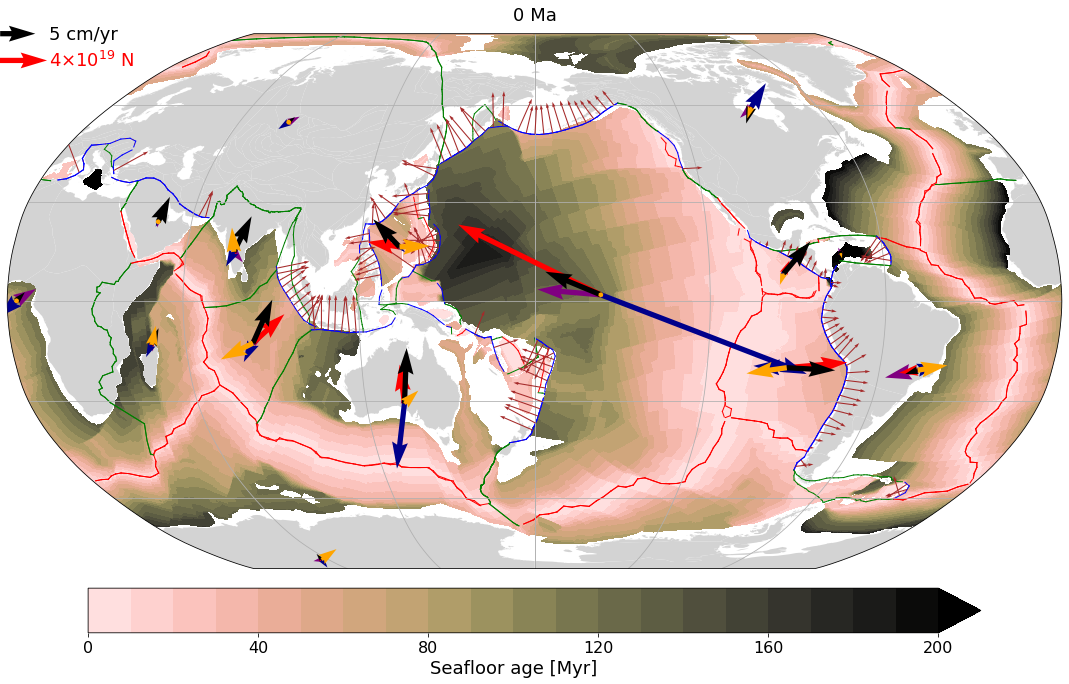

In [13]:
results_directory = 'force_values/'
opt_sp_const = 0.25
opt_visc =1e20
models = ['Muller_etal_2016']
model_index = 0
model_time = 0
file = results_directory+models[model_index]+'/'+str(model_time)+'Ma_'
plot_dir = 'plots/'
if not os.path.exists(plot_dir+models[model_index]):
    os.makedirs(plot_dir+models[model_index])

# load files
plate_id_list = np.load(file+'plate_id_list.npy',allow_pickle=True)
plate_data = np.load(file+'plate_data.npy',allow_pickle=True)
sp_torque = np.load(file+'sp_torque.npy',allow_pickle=True)
bend_torque = np.load(file+'bend_torque.npy',allow_pickle=True)
rp_torque = np.load(file+'rp_torque.npy',allow_pickle=True)
gpe_torque = np.load(file+'gpe_torque.npy',allow_pickle=True)
md_ocean_torque = np.load(file+'md_ocean_torque.npy',allow_pickle=True)
md_cont_torque = np.load(file+'md_cont_torque.npy',allow_pickle=True)
centroid_vels = np.load(file+'centroid_vels.npy',allow_pickle=True)
platebound_coords = np.load(file+'platebound_coords.npy',allow_pickle=True)
sp_segs = np.load(file+'sp_segs.npy',allow_pickle=True)
rp_segs = np.load(file+'rp_segs.npy',allow_pickle=True)

# Change these if using a different model to Muller et al. (2016)
seafloor_ages = 'Seafloor_age_data/Muller_etal_2016_AREPS_v1.17_netCDF/Muller_etal_2016_AREPS_v1.17_AgeGrid-' + str(int(model_time)) + '.nc'
crustal_thickness = 'Crustal_thickness/Muller_etal_2016/raster_data_cthick_new_'+str(int(model_time))+'.00Ma.nc'


total_sp_torque = np.zeros([0,4])
total_bend_torque = np.zeros([0,4])
total_gpe_torque = np.zeros([0,4])
total_md_torque = np.zeros([0,4])
total_res_torque = np.zeros([0,4])
total_total_torque = np.zeros([0,4])
total_total_torque1 = np.zeros([0,4])

for i in range(len(plate_id_list)):
    tau_sp = sp_torque[i] * opt_sp_const
    tau_bend = bend_torque[i]
    tau_gpe = gpe_torque[i]
    tau_mdo = md_ocean_torque[i] * (opt_visc/150e3)
    tau_mdc = md_cont_torque[i] * (opt_visc/150e3)
    tau_md = np.sum([tau_mdo, tau_mdc],axis=0)
    tau_res = np.sum([tau_sp, tau_gpe,tau_md],axis=0) * -1
    tau_tot = np.sum([tau_sp,tau_bend,tau_gpe],axis=0)
    tau_tot1 = np.sum([tau_sp,tau_gpe],axis=0)

    # Get Centroid
    lon_cent = np.deg2rad(plate_data[i][0])
    lat_cent = np.deg2rad(plate_data[i][1])
    centroid_cart = 6378.1e3 * np.array([np.cos(lat_cent) * np.cos(lon_cent), np.cos(lat_cent) * np.sin(lon_cent), np.sin(lat_cent)])
    centroid = pygplates.PointOnSphere(plate_data[i][1],plate_data[i][0])
    
    # Get force acting at centroid
    area_normalize = False
    if area_normalize == True:
        sp_force_cart = np.cross(tau_sp,centroid_cart)/plate_data[i][2]
        bend_force_cart = np.cross(tau_bend,centroid_cart)/plate_data[i][2]
        md_force_cart = np.cross(tau_md,centroid_cart)/plate_data[i][2]
        gpe_force_cart = np.cross(tau_gpe,centroid_cart)/plate_data[i][2]
        res_force_cart = np.cross(tau_res,centroid_cart)/plate_data[i][2]
        tot_force_cart = np.cross(tau_tot,centroid_cart)/plate_data[i][2]
        tot_force_cart1 = np.cross(tau_tot1,centroid_cart)/plate_data[i][2]
    else:
        sp_force_cart = np.cross(tau_sp,centroid_cart)/(np.sqrt(centroid_cart[0]**2 + centroid_cart[1]**2 + centroid_cart[2]**2)**2)
        bend_force_cart = np.cross(tau_bend,centroid_cart)/(np.sqrt(centroid_cart[0]**2 + centroid_cart[1]**2 + centroid_cart[2]**2)**2)
        md_force_cart = np.cross(tau_md,centroid_cart)/(np.sqrt(centroid_cart[0]**2 + centroid_cart[1]**2 + centroid_cart[2]**2)**2)
        gpe_force_cart = np.cross(tau_gpe,centroid_cart)/(np.sqrt(centroid_cart[0]**2 + centroid_cart[1]**2 + centroid_cart[2]**2)**2)
        res_force_cart = np.cross(tau_res,centroid_cart)/(np.sqrt(centroid_cart[0]**2 + centroid_cart[1]**2 + centroid_cart[2]**2)**2)
        tot_force_cart = np.cross(tau_tot,centroid_cart)/(np.sqrt(centroid_cart[0]**2 + centroid_cart[1]**2 + centroid_cart[2]**2)**2)
        tot_force_cart1 = np.cross(tau_tot1,centroid_cart)/(np.sqrt(centroid_cart[0]**2 + centroid_cart[1]**2 + centroid_cart[2]**2)**2)
    
    # convert from cartesian to magnitude/azimuth
    sp_mag_azi = pygplates.LocalCartesian.convert_from_geocentric_to_magnitude_azimuth_inclination(centroid,sp_force_cart)
    bend_mag_azi = pygplates.LocalCartesian.convert_from_geocentric_to_magnitude_azimuth_inclination(centroid,bend_force_cart)
    md_mag_azi = pygplates.LocalCartesian.convert_from_geocentric_to_magnitude_azimuth_inclination(centroid,md_force_cart)
    gpe_mag_azi = pygplates.LocalCartesian.convert_from_geocentric_to_magnitude_azimuth_inclination(centroid,gpe_force_cart)
    res_mag_azi = pygplates.LocalCartesian.convert_from_geocentric_to_magnitude_azimuth_inclination(centroid,res_force_cart)
    tot_mag_azi = pygplates.LocalCartesian.convert_from_geocentric_to_magnitude_azimuth_inclination(centroid,tot_force_cart)
    tot_mag_azi1 = pygplates.LocalCartesian.convert_from_geocentric_to_magnitude_azimuth_inclination(centroid,tot_force_cart1)
    
    # append to arrays
    total_sp_torque = np.append(total_sp_torque, np.array([[plate_data[i][0], plate_data[i][1], sp_mag_azi[0], sp_mag_azi[1]]]), axis=0)
    total_bend_torque = np.append(total_bend_torque, np.array([[plate_data[i][0], plate_data[i][1], bend_mag_azi[0], bend_mag_azi[1]]]), axis=0)
    total_gpe_torque = np.append(total_gpe_torque, np.array([[plate_data[i][0], plate_data[i][1], gpe_mag_azi[0], gpe_mag_azi[1]]]), axis=0)
    total_md_torque = np.append(total_md_torque, np.array([[plate_data[i][0], plate_data[i][1], md_mag_azi[0], md_mag_azi[1]]]), axis=0)
    total_res_torque = np.append(total_res_torque, np.array([[plate_data[i][0], plate_data[i][1], res_mag_azi[0], res_mag_azi[1]]]), axis=0)
    total_total_torque = np.append(total_total_torque, np.array([[plate_data[i][0], plate_data[i][1], tot_mag_azi[0], tot_mag_azi[1]]]), axis=0)
    total_total_torque1 = np.append(total_total_torque1, np.array([[plate_data[i][0], plate_data[i][1], tot_mag_azi1[0], tot_mag_azi1[1]]]), axis=0)
    
# Set options for plotting
plot_options = {'centroid_vels':True,
               'bending':False,
               'slab pull':True,
               'ridge push':False,
               'gpe':True,
               'mantle drag':True,
               'residual torque':True,
               'sp segments':True,
               'rp segments':False,
               'seafloor agegrid':True,
               'normalize':4e18,           # <----- change to scale the arrows
               'vector scale':10,
               'vector label':r'4$\times$$\mathregular{10^{19}}$ N',
               'save':False,
               'name':'plots/'+models[model_index]+'_'+str(model_time)+'Ma_plot'}

plot_plateforce_map(coastlines[model_index],rotation_model[model_index],model_time,total_sp_torque,total_bend_torque,None,total_gpe_torque,
                   total_md_torque,None,total_res_torque,centroid_vels,platebound_coords,sp_segs,rp_segs,seafloor_ages,plot_options)

### Residual Magnitude

#### Single Plate

12
0.027755095979286624
14
0.03305682895906869
13
0.03644383454863107
12
0.06753541217490415
14
0.0319899039081318


(0.0, 120.0)

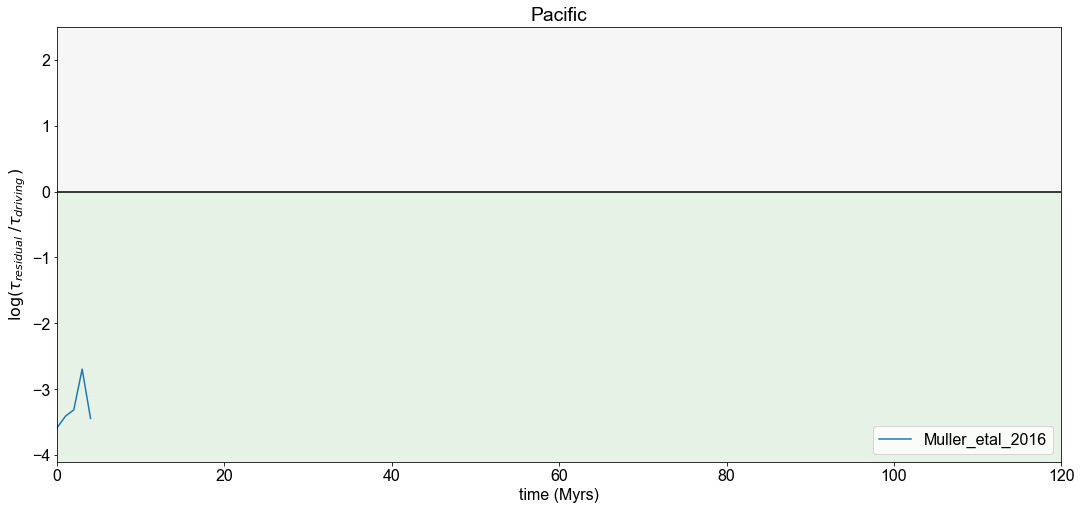

In [34]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
models = ['Muller_etal_2016']
times = [*range(0,121,1)]
ratios = np.zeros([len(models),len(times)])

# Set optimized parameters
sp_consts = [opt_sp_const]
viscs = [opt_visc]
Plate_ID_of_interest = [901]
plate_name = 'Pacific'

for model_index in [0]:   # change for different models
    for t in range(len(times)):
        time = times[t]
        file = results_directory+models[model_index]+'/'+str(time)+'Ma_'

        # load files
        plate_id_list = np.load(file+'plate_id_list.npy',allow_pickle=True)
        sp_torque = np.load(file+'sp_torque.npy',allow_pickle=True)
        bend_torque = np.load(file+'bend_torque.npy',allow_pickle=True)
        rp_torque = np.load(file+'rp_torque.npy',allow_pickle=True)
        gpe_torque = np.load(file+'gpe_torque.npy',allow_pickle=True)
        md_ocean_torque = np.load(file+'md_ocean_torque.npy',allow_pickle=True)
        md_cont_torque = np.load(file+'md_cont_torque.npy',allow_pickle=True)

        try:
            plate = np.where(plate_id_list == Plate_ID_of_interest)[0][0]
            tau_sp = sp_torque[plate] * sp_consts[model_index]
            sp_mag = np.sqrt(tau_sp[0]**2 + tau_sp[1]**2 + tau_sp[2]**2)
            tau_bend = bend_torque[plate]
            tau_gpe = gpe_torque[plate]
            tau_mdo = md_ocean_torque[plate] * (viscs[model_index]/150e3)
            tau_mdc = md_cont_torque[plate] * (viscs[model_index]/150e3)
            tau_md = np.sum([tau_mdo, tau_mdc],axis=0)
            tau_res = np.sum([tau_sp,tau_gpe,tau_md],axis=0) * -1
            tau_tot = np.sum([tau_sp,tau_gpe],axis=0)
            res_mag = np.sqrt(tau_res[0]**2 + tau_res[1]**2 + tau_res[2]**2)
            tot_mag = np.sqrt(tau_tot[0]**2 + tau_tot[1]**2 + tau_tot[2]**2)
            mag = res_mag/tot_mag    
            ratios[model_index][t] = np.log(mag)
        except:
            ratios[model_index][t] = None

font = {'size':16}
plt.rcParams['font.family'] = "Arial"
plt.rc('font',**font)
plt.figure(figsize=(18,8))
ax = plt.gca()
ax.add_patch( patches.Rectangle( (0, -4.1), 120, 4.1, linewidth=1, edgecolor='gray',
            facecolor='green', alpha=0.1 ) )
ax.add_patch( patches.Rectangle( (0, 0), 120, 2.5, linewidth=1, edgecolor='white',
            facecolor='lightgrey', alpha=0.2 ) )
ax.plot([0,120],[0,0],'k-')
ax.plot(times,ratios[0],label=models[0])
# ax.plot(times,ratios[1],label=models[1])
plt.title(titles[0])
plt.ylabel(r'$\log(\tau_{residual}\;/\tau_{driving}\,)$')
plt.xlabel('time (Myrs)')
plt.legend(loc='lower right')
plt.ylim(-4.1,2.5)
plt.xlim(0,120)

#### All Plates

(0.0, 120.0)

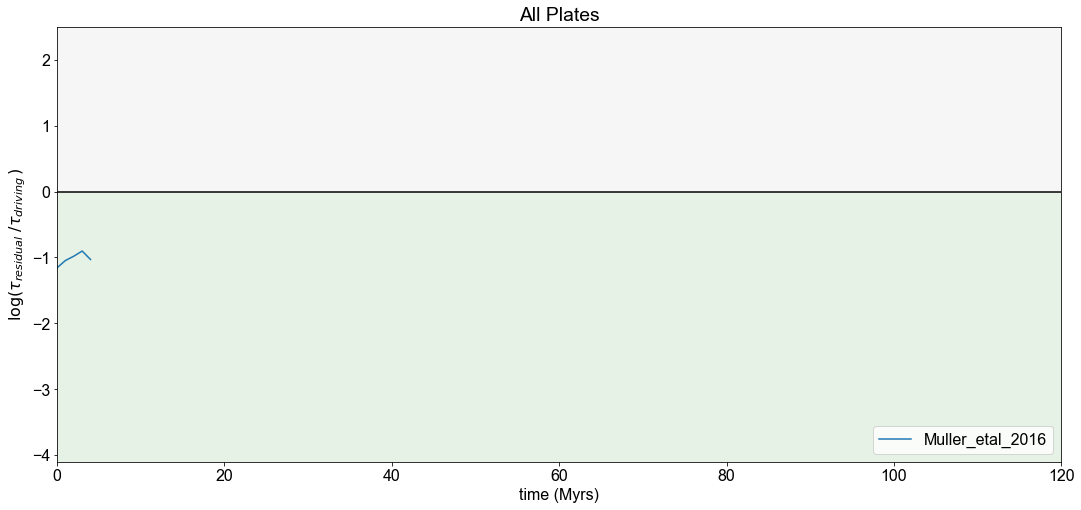

In [36]:
ratios = np.zeros([len(models),len(times)])
area_weighting = True

sp_consts = [opt_sp_const]
viscs = [opt_visc]

for model_index in [0]:
    for t in range(len(times)):
        time = times[t]
        file = results_directory+models[model_index]+'/'+str(time)+'Ma_'

        # load files
        plate_id_list = np.load(file+'plate_id_list.npy',allow_pickle=True)
        plate_data = np.load(file+'plate_data.npy',allow_pickle=True)
        sp_torque = np.load(file+'sp_torque.npy',allow_pickle=True)
        bend_torque = np.load(file+'bend_torque.npy',allow_pickle=True)
        rp_torque = np.load(file+'rp_torque.npy',allow_pickle=True)
        gpe_torque = np.load(file+'gpe_torque.npy',allow_pickle=True)
        md_ocean_torque = np.load(file+'md_ocean_torque.npy',allow_pickle=True)
        md_cont_torque = np.load(file+'md_cont_torque.npy',allow_pickle=True)

        ratio = []
        oce_ratio = []
        areas = []
        oce_areas = []
        for plate in range(len(plate_id_list)):
            pid = plate_id_list[plate]
            tau_sp = sp_torque[plate] * sp_consts[model_index]
            sp_mag = np.sqrt(tau_sp[0]**2 + tau_sp[1]**2 + tau_sp[2]**2)
            tau_bend = bend_torque[plate]
            tau_gpe = gpe_torque[plate]
            tau_mdo = md_ocean_torque[plate] * (viscs[model_index]/150e3)
            tau_mdc = md_cont_torque[plate] * (viscs[model_index]/150e3)
            tau_md = np.sum([tau_mdo, tau_mdc],axis=0)
            tau_res = np.sum([tau_sp,tau_gpe,tau_md],axis=0) * -1
            tau_tot = np.sum([tau_sp,tau_gpe],axis=0)
            res_mag = np.sqrt(tau_res[0]**2 + tau_res[1]**2 + tau_res[2]**2)
            tot_mag = np.sqrt(tau_tot[0]**2 + tau_tot[1]**2 + tau_tot[2]**2)
            mag = res_mag/tot_mag
            if str(mag) != 'nan' and str(mag) != 'inf':
                ratio.append(np.log(mag))
                areas.append(plate_data[plate][2])

        if area_weighting == True:
            denom = areas.index(min(areas))
            weight = []
            for i in range(len(areas)):
                weight.append((areas[i]/areas[denom])*ratio[i])
            tot_w = sum(areas)/areas[denom]
            ratios[model_index][t] = sum(weight)/tot_w
        else:
            ratios[model_index][t] = mean(ratio)
        
font = {'size':16}
plt.rcParams['font.family'] = "Arial"
plt.rc('font',**font)
plt.figure(figsize=(18,8))
ax = plt.gca()
ax.add_patch( patches.Rectangle( (0, -4.1), 120, 4.1, linewidth=1, edgecolor='gray',
            facecolor='green', alpha=0.1 ) )
ax.add_patch( patches.Rectangle( (0, 0), 120, 2.5, linewidth=1, edgecolor='white',
            facecolor='lightgrey', alpha=0.2 ) )
ax.plot([0,120],[0,0],'k-')
ax.plot(times,ratios[0],label=models[0])
# ax.plot(times,ratios[1],label=models[1])
plt.title('All Plates')
plt.ylabel(r'$\log(\tau_{residual}\;/\tau_{driving}\,)$')
plt.xlabel('time (Myrs)')
plt.legend(loc='lower right')
plt.ylim(-4.1,2.5)
plt.xlim(0,120)

### Residual azimuths

In [38]:
models = ['Muller_etal_2016']
model_index = 0
times = [*range(0,121,1)]
sp_azi_list = np.zeros([len(models),len(times)])
tot_azi_list = np.zeros([len(models),len(times)])
res_azi_list = np.zeros([len(models),len(times)])
md_azi_list = np.zeros([len(models),len(times)])
vel_azi_list = np.zeros([len(models),len(times)])
res_mag_list = np.zeros([len(models),len(times)])
Plate_ID_of_interest = 901       # Pacific Plate

for time in times:
    file = 'force_values/'+models[model_index]+'/'+str(time)+'Ma_'

    # load files
    plate_id_list = np.load(file+'plate_id_list.npy',allow_pickle=True)
    plate_data = np.load(file+'plate_data.npy',allow_pickle=True)
    sp_torque = np.load(file+'sp_torque.npy',allow_pickle=True)
    bend_torque = np.load(file+'bend_torque.npy',allow_pickle=True)
    rp_torque = np.load(file+'rp_torque.npy',allow_pickle=True)
    gpe_torque = np.load(file+'gpe_torque.npy',allow_pickle=True)
    md_ocean_torque = np.load(file+'md_ocean_torque.npy',allow_pickle=True)
    md_cont_torque = np.load(file+'md_cont_torque.npy',allow_pickle=True)
    centroid_vels = np.load(file+'centroid_vels.npy',allow_pickle=True)
    platebound_coords = np.load(file+'platebound_coords.npy',allow_pickle=True)

    try:
        i = np.where(plate_id_list == Plate_ID_of_interest)[0][0]
        tau_sp = sp_torque[i] * opt_sp_const
        tau_bend = bend_torque[i]
        tau_gpe = gpe_torque[i]
        tau_mdo = md_ocean_torque[i] * (opt_visc/150e3)
        tau_mdc = md_cont_torque[i] * (opt_visc/150e3)
        tau_md = np.sum([tau_mdo, tau_mdc],axis=0)
        tau_res = np.sum([tau_sp,tau_bend, tau_gpe,tau_md],axis=0) * -1
        tau_tot = np.sum([tau_sp,tau_gpe],axis=0)

        # Get Centroid
        lon_cent = np.deg2rad(plate_data[i][0])
        lat_cent = np.deg2rad(plate_data[i][1])
        centroid_cart = 6378.1e3 * np.array([np.cos(lat_cent) * np.cos(lon_cent), np.cos(lat_cent) * np.sin(lon_cent), np.sin(lat_cent)])
        centroid = pygplates.PointOnSphere(plate_data[i][1],plate_data[i][0])

        # Get force acting at centroid
        sp_force_cart = np.cross(tau_sp,centroid_cart)/plate_data[i][2]
        bend_force_cart = np.cross(tau_bend,centroid_cart)/plate_data[i][2]
        md_force_cart = np.cross(tau_md,centroid_cart)/plate_data[i][2]    
        gpe_force_cart = np.cross(tau_gpe,centroid_cart)/plate_data[i][2]
        res_force_cart = np.cross(tau_res,centroid_cart)/plate_data[i][2]
        tot_force_cart = np.cross(tau_tot,centroid_cart)/plate_data[i][2]

        # convert from cartesian to magnitude/azimuth
        sp_mag_azi = pygplates.LocalCartesian.convert_from_geocentric_to_magnitude_azimuth_inclination(centroid,sp_force_cart)
        bend_mag_azi = pygplates.LocalCartesian.convert_from_geocentric_to_magnitude_azimuth_inclination(centroid,bend_force_cart)
        md_mag_azi = pygplates.LocalCartesian.convert_from_geocentric_to_magnitude_azimuth_inclination(centroid,md_force_cart)
        gpe_mag_azi = pygplates.LocalCartesian.convert_from_geocentric_to_magnitude_azimuth_inclination(centroid,gpe_force_cart)
        res_mag_azi = pygplates.LocalCartesian.convert_from_geocentric_to_magnitude_azimuth_inclination(centroid,res_force_cart)
        tot_mag_azi = pygplates.LocalCartesian.convert_from_geocentric_to_magnitude_azimuth_inclination(centroid,tot_force_cart)

        sp_azi_list[model_index][time] = sp_mag_azi[1]
        tot_azi_list[model_index][time] = tot_mag_azi[1]
        res_azi_list[model_index][time] = res_mag_azi[1]
        md_azi_list[model_index][time] = md_mag_azi[1]
        vel_azi_list[model_index][time] = centroid_vels[i][3]
        res_mag_list[model_index][time] = np.log(res_mag_azi[0]/tot_mag_azi[0])

    except:
        sp_azi_list[model_index][time] = None
        tot_azi_list[model_index][time] = None
        res_azi_list[model_index][time] = None
        md_azi_list[model_index][time] = None
        vel_azi_list[model_index][time] = None
        res_mag_list[model_index][time] = None
            
sp_smoothed = np.zeros([len(models),len(times)])
res_smoothed = np.zeros([len(models),len(times)])
tot_smoothed = np.zeros([len(models),len(times)])
vel_smoothed = np.zeros([len(models),len(times)])
md_smoothed = np.zeros([len(models),len(times)])
for model_index in range(len(models)):
    for j in range(len(sp_azi_list[model_index])):
        if sp_azi_list[model_index][j] > 1.5*np.pi/2:
            sp_azi_list[model_index][j] = sp_azi_list[model_index][j] - 2*np.pi
        if res_azi_list[model_index][j] > 1.5*np.pi:
            res_azi_list[model_index][j] = res_azi_list[model_index][j] - 2*np.pi
        if tot_azi_list[model_index][j] > 1.5*np.pi/2:
            tot_azi_list[model_index][j] = tot_azi_list[model_index][j] - 2*np.pi
        if vel_azi_list[model_index][j] > np.pi:
            vel_azi_list[model_index][j] = vel_azi_list[model_index][j] - 2*np.pi
        if md_azi_list[model_index][j] < np.pi/2:
            md_azi_list[model_index][j] = md_azi_list[model_index][j] + 2*np.pi
    first_value = 0
    for i in range(len(sp_azi_list[model_index])):
        if sp_azi_list[model_index][i] == None:
            sp_smoothed[model_index][i] = sp_azi_list[model_index][i]
            res_smoothed[model_index][i] = res_azi_list[model_index][i]
            tot_smoothed[model_index][i] = tot_azi_list[model_index][i]
            vel_smoothed[model_index][i] = vel_azi_list[model_index][i]
            md_smoothed[model_index][i] = md_azi_list[model_index][i]
            first_value += 1
        if i>= first_value + 2 and i <= len(sp_azi_list[model_index])-3:
            sp_smoothed[model_index][i] = (sp_azi_list[model_index][i-2] + sp_azi_list[model_index][i-1] + sp_azi_list[model_index][i] + sp_azi_list[model_index][i+1] + sp_azi_list[model_index][i+2])/5
            res_smoothed[model_index][i] = (res_azi_list[model_index][i-2] + res_azi_list[model_index][i-1] + res_azi_list[model_index][i] + res_azi_list[model_index][i+1] + res_azi_list[model_index][i+2])/5
            tot_smoothed[model_index][i] = (tot_azi_list[model_index][i-2] + tot_azi_list[model_index][i-1] + tot_azi_list[model_index][i] + tot_azi_list[model_index][i+1] + tot_azi_list[model_index][i+2])/5
            vel_smoothed[model_index][i] = (vel_azi_list[model_index][i-2] + vel_azi_list[model_index][i-1] + vel_azi_list[model_index][i] + vel_azi_list[model_index][i+1] + vel_azi_list[model_index][i+2])/5
            md_smoothed[model_index][i] = (md_azi_list[model_index][i-2] + md_azi_list[model_index][i-1] + md_azi_list[model_index][i] + md_azi_list[model_index][i+1] + md_azi_list[model_index][i+2])/5
        if i == first_value or i == len(sp_azi_list[model_index])-1:
            sp_smoothed[model_index][i] = sp_azi_list[model_index][i]
            res_smoothed[model_index][i] = res_azi_list[model_index][i]
            tot_smoothed[model_index][i] = tot_azi_list[model_index][i]
            vel_smoothed[model_index][i] = vel_azi_list[model_index][i]
            md_smoothed[model_index][i] = md_azi_list[model_index][i]
        if i == first_value + 1 or i == len(sp_azi_list[model_index])-2:
            sp_smoothed[model_index][i] = (sp_azi_list[model_index][i-1] + sp_azi_list[model_index][i] + sp_azi_list[model_index][i+1])/3
            res_smoothed[model_index][i] = (res_azi_list[model_index][i-1] + res_azi_list[model_index][i] + res_azi_list[model_index][i+1])/3
            tot_smoothed[model_index][i] = (tot_azi_list[model_index][i-1] + tot_azi_list[model_index][i] + tot_azi_list[model_index][i+1])/3
            vel_smoothed[model_index][i] = (vel_azi_list[model_index][i-1] + vel_azi_list[model_index][i] + vel_azi_list[model_index][i+1])/3
            md_smoothed[model_index][i] = (md_azi_list[model_index][i-1] + md_azi_list[model_index][i] + md_azi_list[model_index][i+1])/3

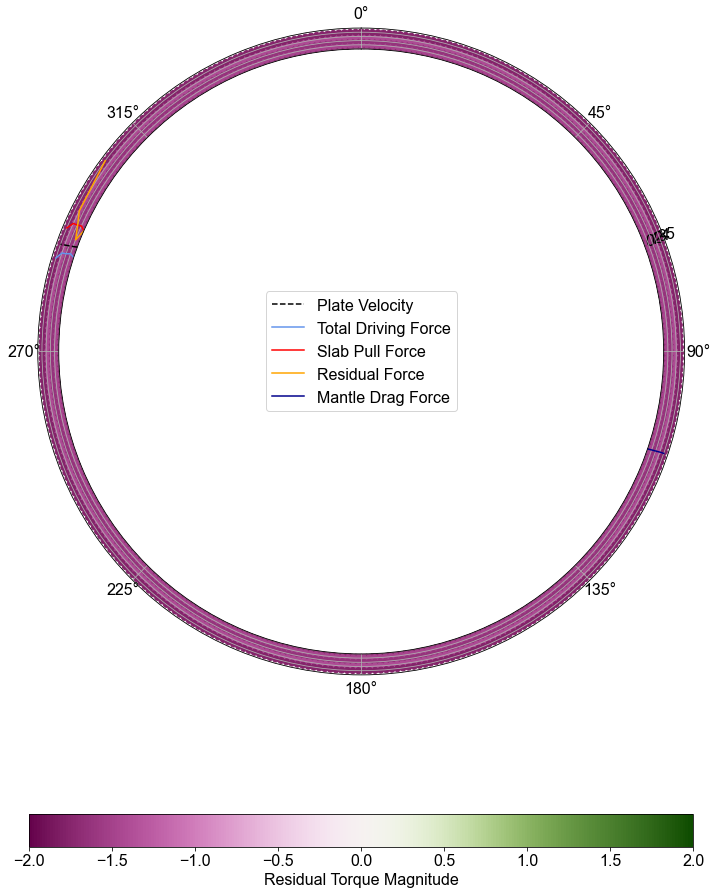

In [44]:
import matplotlib.pyplot as plt
import matplotlib.font_manager
from matplotlib.colors import BoundaryNorm, ListedColormap
from cmcrameri import cm

font = {'size':16}
plt.rcParams['font.family'] = "Arial"
plt.rc('font',**font)
model_index = 0
smooth = True
mags = True
if mags == True:
    fig, ax = plt.subplots(subplot_kw={'projection': 'polar'},figsize=(17,17))
else:
    fig, ax = plt.subplots(subplot_kw={'projection': 'polar'},figsize=(12,12))
    
if smooth == True:
    ax.plot(vel_smoothed[model_index],times,'k--',label='Plate Velocity')
    ax.plot(tot_smoothed[model_index], times,color='cornflowerblue',label='Total Driving Force')
    ax.plot(sp_smoothed[model_index], times,color='red',label='Slab Pull Force')
    ax.plot(res_smoothed[model_index], times,color='orange',label='Residual Force')
    ax.plot(md_smoothed[model_index],times,color='darkblue',label='Mantle Drag Force')
else:
    ax.plot(vel_azi_list[model_index],times,'k--',label='Plate Velocity')
    ax.plot(sp_azi_list[model_index], times,color='red',label='Slab Pull Force')
    ax.plot(res_azi_list[model_index], times,color='orange',label='Residual Force')
    ax.plot(tot_azi_list[model_index], times,color='cornflowerblue',label='Total Driving Force')
    ax.plot(md_azi_list[model_index],times,color='darkblue',label='Mantle Drag Force')

if mags == True:
    for i in np.linspace(0,np.pi*2,360):
        theta = np.ones(121)*i
        ax.scatter(theta,times,c=res_mag_list[0],cmap=cm.bam,vmin=-2,vmax=2)
    f1 = ax.scatter(theta,times,c=res_mag_list[0],cmap=cm.bam,vmin=-2,vmax=2)
    cbar = plt.colorbar(f1,orientation='horizontal',shrink=0.7)
    cbar.set_label('Residual Torque Magnitude')
ax.set_rorigin(-72)
ax.set_rmax(120)
ax.set_rticks([0, 30, 60, 90,120]) 
ax.set_rlabel_position(70)  # Move radial labels away from plotted line
ax.set_theta_zero_location("N")
ax.set_theta_direction(-1)
ax.grid(True)
ax.legend(loc = 'center')
plt.show()